Interactively figure out MGRS tiles and track numbers

In [1]:
import asf_search as asf
import geopandas as gpd
from shapely.geometry import box
from shapely.ops import unary_union
from shapely import force_2d
from rasterio.crs import CRS
import pandas as pd
import yaml
from pathlib import Path
from tqdm import tqdm
import rasterio
import numpy as np
from asf_search import ASFSession
import http.cookiejar
from dem_stitcher.geojson_io import read_geojson_gzip
import backoff
from skimage.restoration import denoise_tv_bregman
import matplotlib.pyplot as plt

# Load Event Data

In [14]:
yaml_file = 'events/tuscany_flood_2023.yml'
with open(yaml_file) as f:
    event_dict = yaml.safe_load(f)["event"]
event_dict

{'event_name': 'tuscany_flood_2023',
 'bounds': [10.97631339, 43.81441325, 11.15319728, 43.98650075],
 'event_date': '2023-11-02',
 'pre_event_window_days': 100,
 'post_event_window_days': 60,
 'rtc_track_numbers': [150, 114],
 'mgrs_tiles': ['32TPP'],
 'dist_hls_confirmed_change_min_days': 30,
 'source_id': 'Copernicus EMSN185',
 'links': ['https://emergency.copernicus.eu/mapping/list-of-components/EMSN185',
  'https://earthobservatory.nasa.gov/images/152051/flooding-in-tuscany']}

# Read Geojson

In [5]:
p_json = Path(f'external_validation_data_db/{event_dict["event_name"]}.geojson')
p_parq = Path(f'external_validation_data_db/{event_dict["event_name"]}.parquet')
if p_json.exists():
    df_event = gpd.read_file(p_json)
else:
    df_event = gpd.read_parquet(p_parq)

<Axes: >

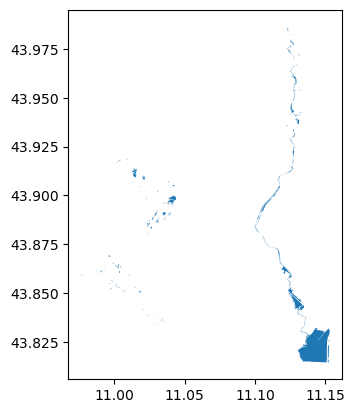

In [6]:
df_event.plot()

In [7]:
df_event.head()

name       date                      source_id  \
0  tuscany_flood_2023 2023-11-02  Copernicus Copernicus EMSN185   

                                            geometry  
0  MULTIPOLYGON (((10.97632 43.84244, 10.97635 43...

In [8]:
df_event.total_bounds

array([10.97631339, 43.81441325, 11.15319728, 43.98650075])

# Create Spatial AOI

In [9]:
aoi = box(*df_event.total_bounds)
df_aoi = gpd.GeoDataFrame(geometry=[aoi], crs=CRS.from_epsg(4326))

In [10]:
bounds = aoi.bounds
bounds

(10.976313388750667, 43.81441324643827, 11.15319727641426, 43.986500753248485)

# Find MGRS tiles and Explore

In [11]:
df_mgrs = gpd.read_parquet('mgrs.parquet')
df_mgrs_overlapping = df_mgrs[df_mgrs.geometry.intersects(aoi)].reset_index(drop=True)
# remove antimeridian
df_mgrs_overlapping = df_mgrs_overlapping[~df_mgrs_overlapping.intersects(box(-180, -60, -179, 60))]
df_mgrs_overlapping.head()

tile_id    epsg                                            utm_wkt  \
1   32TPP   32632  MULTIPOLYGON(((600000 4900020,600000 4790220,7...   

                                            geometry  
1  MULTIPOLYGON (((10.25248 44.24655, 10.23203 43...

In [12]:
m = df_mgrs_overlapping.explore(column='tile_id', categorical=True)
df_aoi.exterior.explore(m=m, style_kwds={'color':'black'})

# Select MGRS Tile(s)

In [15]:
MGRS_TILES = event_dict['mgrs_tiles']
MGRS_TILES

['32TPP']

In [16]:
df_mgrs_search = df_mgrs_overlapping[df_mgrs_overlapping.tile_id.isin(MGRS_TILES)].reset_index(drop=True)
search_geo = df_mgrs_search.geometry.unary_union

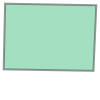

In [17]:
search_geo

# Explore Availability of RTC Data

In [18]:
import datetime
EVENT_DT = datetime.datetime.strptime(event_dict['event_date'], "%Y-%m-%d")
PRE_DT_START = EVENT_DT - datetime.timedelta(days=event_dict['pre_event_window_days'])
POST_DT_STOP = EVENT_DT + datetime.timedelta(days=event_dict['post_event_window_days'])


In [19]:
resp_pre = asf.geo_search(intersectsWith=search_geo.wkt,
                          processingLevel='RTC',
                          platform=asf.constants.SENTINEL1, 
                          start=PRE_DT_START, 
                          end=EVENT_DT)
len(resp_pre)

147

In [20]:
resp_post = asf.geo_search(intersectsWith=search_geo.wkt,
                           processingLevel='RTC',
                           platform=asf.constants.SENTINEL1, 
                           start=EVENT_DT, 
                           end=POST_DT_STOP)
len(resp_post)

465

In [26]:
df_rtc_resp_pre_e = gpd.GeoDataFrame.from_features(resp_pre.geojson(), crs=CRS.from_epsg(4326))
#df_rtc_resp_pre_e = df_rtc_resp_pre_e[df_rtc_resp_pre_e.pathNumber == 130].reset_index(drop=True)
df_rtc_resp_pre_e['geometry'] = df_rtc_resp_pre_e['geometry'].boundary
m = df_rtc_resp_pre_e.explore(alpha=.1, column='pathNumber', categorical=True, cmap='tab20c')
if MGRS_TILES is not None:
    df_mgrs_search.explore(m=m)
df_aoi.explore(m=m)
m

In [22]:
df_rtc_resp_pre_e.pathNumber.unique()

array([ 15, 168,  95, 117])

In [28]:
df_rtc_resp_post_e = gpd.GeoDataFrame.from_features(resp_post.geojson(), crs=CRS.from_epsg(4326))
#df_rtc_resp_post_e = df_rtc_resp_post_e[df_rtc_resp_post_e.pathNumber.isin([ 15, 168])].boundary.reset_index(drop=True)
m = df_rtc_resp_post_e.explore()
if MGRS_TILES is not None:
    df_mgrs_search.explore(m=m)

m

In [29]:
df_rtc_resp_post_e.head()

geometry  centerLat  centerLon  \
0  POLYGON ((9.28638 44.06601, 9.91142 44.14582, ...  44.225848   9.877423   
1  POLYGON ((10.41101 44.09565, 10.95503 44.15993...  44.240568  10.925181   
2  POLYGON ((9.32850 43.90051, 10.54139 44.05249,...  44.059721   9.917297   
3  POLYGON ((10.44830 43.92995, 10.98650 43.99377...  44.074982  10.960435   
4  POLYGON ((9.37049 43.73499, 9.99080 43.81465, ...  43.894460   9.953174   

               stopTime                                             fileID  \
0  2023-12-30T17:15:15Z  OPERA_L2_RTC-S1_T015-030331-IW2_20231230T17151...   
1  2023-12-30T17:15:13Z  OPERA_L2_RTC-S1_T015-030330-IW3_20231230T17151...   
2  2023-12-30T17:15:12Z  OPERA_L2_RTC-S1_T015-030330-IW2_20231230T17150...   
3  2023-12-30T17:15:11Z  OPERA_L2_RTC-S1_T015-030329-IW3_20231230T17150...   
4  2023-12-30T17:15:10Z  OPERA_L2_RTC-S1_T015-030329-IW2_20231230T17150...   

  flightDirection  pathNumber processingLevel  \
0       ASCENDING          15             RTC   
1       ASCENDING          15             RTC   
2       ASCENDING          15             RTC   
3       ASCENDING          15             RTC   
4       ASCENDING          15             RTC   

                                                 url             startTime  \
0  https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...  2023-12-30T17:15:12Z   
1  https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...  2023-12-30T17:15:10Z   
2  https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...  2023-12-30T17:15:09Z   
3  https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...  2023-12-30T17:15:08Z   
4  https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...  2023-12-30T17:15:07Z   

   ... validityStartDate subswath  \
0  ...              None      IW2   
1  ...              None      IW3   
2  ...              None      IW2   
3  ...              None      IW3   
4  ...              None      IW2   

                                            fileName beamModeType  \
0  OPERA_L2_RTC-S1_T015-030331-IW2_20231230T17151...           IW   
1  OPERA_L2_RTC-S1_T015-030330-IW3_20231230T17151...           IW   
2  OPERA_L2_RTC-S1_T015-030330-IW2_20231230T17150...           IW   
3  OPERA_L2_RTC-S1_T015-030329-IW3_20231230T17150...           IW   
4  OPERA_L2_RTC-S1_T015-030329-IW2_20231230T17150...           IW   

                                              s3Urls beamMode  \
0  [s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...       IW   
1  [s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...       IW   
2  [s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...       IW   
3  [s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...       IW   
4  [s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...       IW   

                                      additionalUrls bistaticDelayCorrection  \
0  [https://datapool.asf.alaska.edu/RTC/OPERA-S1/...                    TRUE   
1  [https://datapool.asf.alaska.edu/RTC/OPERA-S1/...                    TRUE   
2  [https://datapool.asf.alaska.edu/RTC/OPERA-S1/...                    TRUE   
3  [https://datapool.asf.alaska.edu/RTC/OPERA-S1/...                    TRUE   
4  [https://datapool.asf.alaska.edu/RTC/OPERA-S1/...                    TRUE   

  noiseCorrection postProcessingFilter  
0            TRUE                FALSE  
1            TRUE                FALSE  
2            TRUE                FALSE  
3            TRUE                FALSE  
4            TRUE                FALSE  

[5 rows x 33 columns]